# Project 1

### Question:

What is the mean of the distribution of the depth of exoplanet TOI-564 b's transit?

The transit depth of an exoplanet is the fractional change in brightness of a planet. We are interested in the depth of exoplanet TOI-564 b, as this will allow us to identify the size of this exoplanet. The answer to this question could also hint at whether TOI-564 b has a stable orbit, or if there is another planet in the system causing timing variations.


In [5]:
# importing packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from astropy.io import fits
import lightkurve
import random


## Preparing the Data

In [6]:
#### Importing data ###

# importing light curve file into a pandas dataframe

with fits.open('tess2021014023720-s0034-0000000001003831-0204-s_lc.fits') as data:
    lc = pd.DataFrame(data[1].data)
# lc.close()



# NOTES ---------------- not used  ---------------------------

# target pixle file

# tp = fits.open('tess2021014023720-s0034-0000000001003831-0204-s_tp.fits')
# tp.close()

# dvt file

# dvt = fits.open('tess2021014055109-s0034-s0034-0000000001003831-00444_dvt.fits')
# dvt.close()

In [7]:
### Show dataframe 'lc' ###
lc

,TIME,TIMECORR,CADENCENO,SAP_FLUX,SAP_FLUX_ERR,SAP_BKG,SAP_BKG_ERR,PDCSAP_FLUX,PDCSAP_FLUX_ERR,QUALITY,PSF_CENTR1,PSF_CENTR1_ERR,PSF_CENTR2,PSF_CENTR2_ERR,MOM_CENTR1,MOM_CENTR1_ERR,MOM_CENTR2,MOM_CENTR2_ERR,POS_CORR1,POS_CORR2
0,2228.749744,0.004396,720929,NaN,NaN,NaN,NaN,NaN,NaN,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2228.751133,0.004396,720930,NaN,NaN,NaN,NaN,NaN,NaN,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2228.752521,0.004397,720931,NaN,NaN,NaN,NaN,NaN,NaN,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2228.753910,0.004397,720932,NaN,NaN,NaN,NaN,NaN,NaN,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2228.755299,0.004397,720933,NaN,NaN,NaN,NaN,NaN,NaN,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18226,2254.064045,0.004821,739155,7771.084961,11.317918,1423.796265,4.404044,8521.909180,12.808198,0,NaN,NaN,NaN,NaN,590.700631,0.001352,628.211450,0.001211,0.014498,-0.101497
18227,2254.065434,0.004821,739156,7780.527344,11.319644,1423.212280,4.401287,8544.041016,12.810152,0,NaN,NaN,NaN,NaN,590.690065,0.001355,628.208657,0.001208,0.005521,-0.107459
18228,2254.066823,0.004821,739157,7772.279297,11.325295,1426.134399,4.407309,8535.687500,12.816546,0,NaN,NaN,NaN,NaN,590.693007,0.001354,628.210036,0.001210,0.010873,-0.104120
18229,2254.068212,0.004821,739158,7781.495117,11.323637,1417.161377,4.407610,8544.477539,12.814671,0,NaN,NaN,NaN,NaN,590.694338,0.001352,628.211911,0.001209,0.010618,-0.100834


We plot the SAP and the PDCSAP flux to determine which one to use for our data analysis.

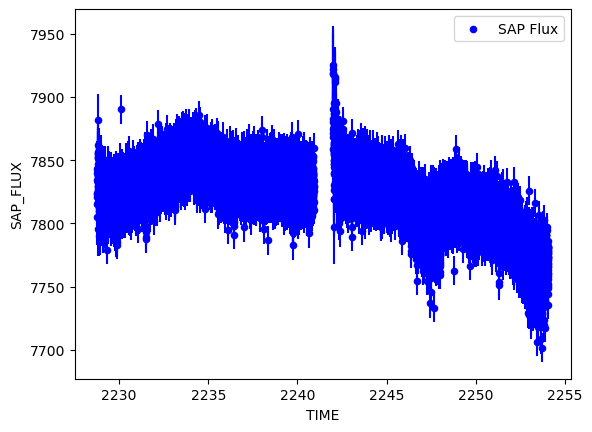

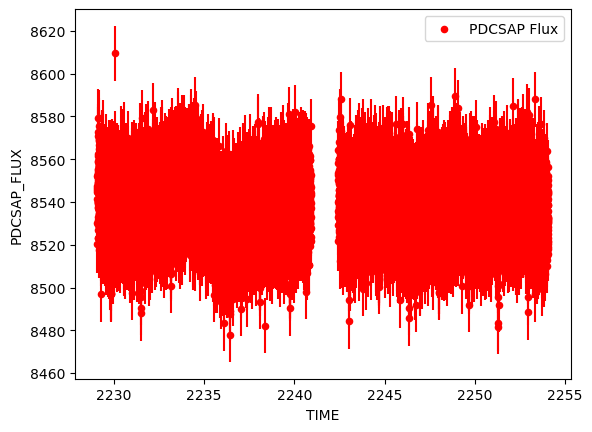

In [8]:
# Plotting SAP Flux in blue
ax1 = lc.plot(x = 'TIME', y = 'SAP_FLUX', yerr = 'SAP_FLUX_ERR', kind = 'scatter', color = 'blue', label = 'SAP Flux')

# Plotting PDCSAP in red
ax2 = lc.plot(x = 'TIME', y = 'PDCSAP_FLUX', yerr = 'PDCSAP_FLUX_ERR', kind = 'scatter', color = 'r', label = 'PDCSAP Flux')

We see that PDCSAP Flux is cleaned, so we will use this flux to determine the transit depth.

We will: 
1. Normalize the PDCSAP Flux data
2. Calculate the average flux over time
3. Determine the time range for each of the 14 transits
4. Calculate the time and depth for each transit

We will then run a Bayesian analysis on the transit depth data.

### 1.

In [9]:
# Normalizing the PDCSAP Flux data:

### 2. 

Below we find the average of the flux over time. This will be used in our calculations to determine the transit depth
** if the data is not normalized at 0 **

In [10]:
y_avg = np.mean(lc['PDCSAP_FLUX'])  # will be 0 or 1 when we normalize the data
print("Average mean of the data:", y_avg)

Average mean of the data: 8537.8935546875


### 3.

By adjusting the lower bound `lb` and upper bound `ub` below, we can manually determine a good time range that captures each transit and allows us to calculate the transit depth. We used this method to determine our time range for each transit, written below.

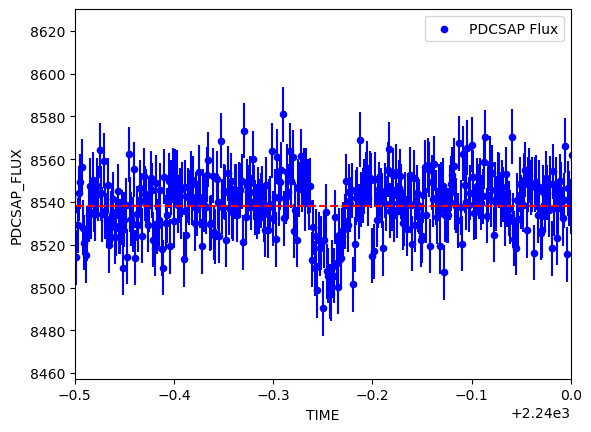

In [11]:
# Finding transit time range using the flux using the cleaned pdcsap data in dataframe 'lc':

lb = 2239.5
ub = 2240

ax3 = lc.plot(x='TIME', 
              y='PDCSAP_FLUX', 
              yerr='PDCSAP_FLUX_ERR', 
              xlim= (lb, ub),
              kind='scatter', 
              color='blue', 
              label='PDCSAP Flux')

ax3.hlines(y=y_avg, 
           xmin=np.min(lc['TIME']), 
           xmax=np.max(lc['TIME']), 
           color='red', 
           linestyle='--', 
           label='average flux')

In [12]:

# begin list of list for time ranges found above

# Transit 1 time range:
time_r = [[2229.7, 2230]]

# Transit 2 time range:
time_r.append([2231.3, 2231.7])

# Transit 3 time range:
time_r.append([2233.05, 2233.25])

# Transit 4 time range:
time_r.append([2234.7, 2234.9])

# Transit 5 time range:
time_r.append([2236.35, 2236.55])

# Transit 6 time range:
time_r.append([2238, 2238.2])

# Transit 7 time range:
time_r.append([2239.65, 2239.85])

# Transit 8 time range:
time_r.append([2243, 2243.2])

# Transit 9 time range:
time_r.append([2244.6, 2244.8])

# Transit 10 time range:
time_r.append([2246.2, 2246.6])

# Transit 11 time range:
time_r.append([2247.7, 2248.2])

# Transit 12 time range:
time_r.append([2249.5, 2249.9])

# Transit 13 time range:
time_r.append([2251.2, 2251.6])

# Transit 14 time range: 
time_r.append ([2252.9, 2253])

print("This is the time range for each transit, beginning with transit 1 and ending with transit 14:")
time_r


This is the time range for each transit, beginning with transit 1 and ending with transit 14:


[[2229.7, 2230],
 [2231.3, 2231.7],
 [2233.05, 2233.25],
 [2234.7, 2234.9],
 [2236.35, 2236.55],
 [2238, 2238.2],
 [2239.65, 2239.85],
 [2243, 2243.2],
 [2244.6, 2244.8],
 [2246.2, 2246.6],
 [2247.7, 2248.2],
 [2249.5, 2249.9],
 [2251.2, 2251.6],
 [2252.9, 2253]]

### 4.

We write a function that returns the time and depth of a transit.

In [13]:
# ######################################################################################
# FUNCTION:         TransitDepth
#
# This function finds the depth and time of a transit.
# Input: range_lb - the lower bound of the time of the transit
#        range_up - the upper bound of the time of the transit
#        plot - Boolean variable: if True, it will plot the transit, min, and average
#
# Output: time - returns the exact time corresponding to the transit depth measured
#         depth - returns the depth measured for the transit at the given time range
#                 which is calculated by subtracting the minumum value from the data mean 
#
# ######################################################################################

def TransitDepth(range_lb, range_ub, plot):
    # create new dataframe with the time frame that captures one transit
    transit = lc[(lc['TIME'] >= range_lb) & (lc['TIME'] <= range_ub)]

    # find depth ___ will not have to subtract average if it is normalized at 0
    depth = y_avg - np.min(transit['PDCSAP_FLUX'])

    # find time corresponding to transit
    time = np.interp(np.min(transit['PDCSAP_FLUX']), transit['PDCSAP_FLUX'], transit['TIME'])       # np.interp(minimum value, y-value, x-value)

    # plots transit if desired
    if plot:
        t = transit.plot(x='TIME', 
                         y='PDCSAP_FLUX', 
                         yerr='PDCSAP_FLUX_ERR',
                         kind='scatter', 
                         color='blue', 
                         label='PDCSAP Flux')

        t.hlines(y=y_avg, 
                 xmin=np.min(transit['TIME']), 
                 xmax=np.max(transit['TIME']), 
                 color='red', 
                 linestyle='--', 
                 label='average flux')

        t.hlines(y=np.min(transit['PDCSAP_FLUX']), 
                 xmin=np.min(transit['TIME']), 
                 xmax=np.max(transit['TIME']), 
                 color='green', 
                 linestyle=':', 
                 label='bottom of transit')
        t.plot
        t.legend()

    return(time, depth)


Here is an example of the output of the function `TransitDepth` as it determins the time and depth of Transit 1:

The time of Transit 1 is:  2229.701167073906
The depth of Transit 1 is:  40.9853515625


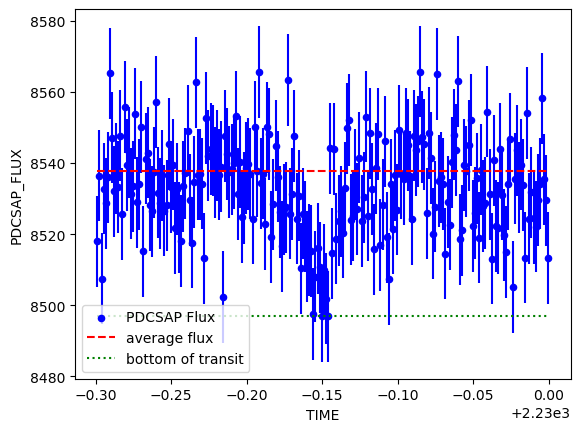

In [14]:
# Transit 1 time range: [2229.7, 2230]:

t, d = TransitDepth(2229.7, 2230, True)
print("The time of Transit 1 is: ", t)
print("The depth of Transit 1 is: ", d)

We will now use our function `TransitDepth` to calculate all the transit depths and times, and create a dataframe `transit_depth` to save our information.

In [15]:
### Create a list of lists to then create the dataframe ###

# initialize list of lists
depth_list = []

### Iterate over time_r to populate 'transit_depth' with the time and depth of each transit ###

for element in time_r:
    #  plot = 0 because we don't want to plot the transit
    t, d = TransitDepth(element[0], element[1], 0)

    # take TransitDepth's return and add it to our list of list 'depth_list'
    depth_list.append([t, d])

# Create the pandas DataFrame
transit_depth = pd.DataFrame(depth_list, columns=['Time', 'Depth'])

In [16]:
# Print dataframe
transit_depth

,Time,Depth
0,2229.701167,40.985352
1,2231.301223,49.975586
2,2233.051279,37.010742
3,2234.701326,31.229492
4,2236.351367,59.870117
5,2238.000014,44.551758
6,2239.650043,47.527344
7,2243.000089,53.594727
8,2244.600115,37.492188
9,2246.200136,52.236328


## Bayesian Analysis

1. Parameter: $\theta$, the mean of the transit depth.
2. Parameter Space: $\Theta$ = [0, 1], since normailzing the data constrained the samples to range between 0 and 1.
3. Data characteristics: $x_i$, $i$ = 1,..., 14, where each $x_i$ is a transit depth measurement.
4. Sample Space: $\mathscr{X}$ = [0, 1], since normailzing the data constrained the samples to range between 0 and 1.
5. Likelihood: 
        We assume the repeated measures of TOI-564 b's transit depth are normally distrubuted and centered around the true mean of the transit depth. In effect, each measurement
        $$
        X_{i} \sim N(\theta, \nu) \text{ for } i = 1,...,14
        $$
        Where $\theta$ is the mean of the transit depth measurments and $\nu$ is the variance of the measurments. We will choose $\nu$ to be the sample variance(??).
6. Prior:
        We are trying to estimate the mean of the transit depth using repeated measures, which means that the posterior distribution for $\theta$ should be normal. We will assume our prior is normally distrubuted to utulize the Normal-Normal conjugate set-up.
        That is, 
        $$
        \theta \sim N($a$, $b$)
        $$
        The mean must lie between zero and one due to our normalization of the data, so we will choose our prior mean $a$ = 0.5, and our prior variance to be $b$ = $\frac{1}{36}. This will make 0 and 1 be 
        
        we will choose our parameters a and b to be such that we will choose our mean to be in the middle of the a = 0.5and we choose a = 0, b = 1